<a href="https://colab.research.google.com/github/invoker-qqwrv/Beida_tensorflow/blob/main/1_7NN_for_Iris_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 流程：1.准备数据：数据集读入，数据集乱序，生成训练集和测试集（x_train,y_train,x_test,y_test），最后配对（输入特征，标签），每次读入一小撮
# 2.搭建网络，定义所有可训练参数
# 3.参数优化，嵌套循环迭代。with语句更新参数。显示当前loss
# 4.测试效果。计算当前参数前后传播的准确率，显示当前acc
# 5.acc/loss可视化

In [6]:
# 1.数据集读入
from sklearn import datasets
from pandas import DataFrame
import pandas as pd
import numpy as np
import tensorflow as tf



x_data=datasets.load_iris().data## all features in datasets
y_data=datasets.load_iris().target#all labels of the datasets

In [7]:
# 数据集乱序
np.random.seed(116)#因为选择相同的随机数种子，所以标签和特征仍然一一对应
np.random.shuffle(x_data)#打乱顺序
np.random.seed(116)
np.random.shuffle(y_data)
tf.random.set_seed(116)#设置全局的随机种子


In [8]:
#区分训练集和测试集
x_train=x_data[:-30]#一共150个数据，取前一百二十个为训练集
y_train=y_data[:-30]
x_test=x_data[-30:]
y_test=y_data[-30:]

In [9]:
#转换x的数据类型。防止矩阵相乘时因为数据类型不同而报错
x_train=tf.cast(x_train,tf.float32)
x_test=tf.cast(x_test,tf.float32)

In [10]:
#features和labels打包，每次喂入一小撮32个
train_db=tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(32)
test_db=tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(32)

In [26]:
# 定义神经网络所有可训练参数
# 生成神经网络的参数，4个输入特征，输入层为4个输入节点；因为3分类，故输出层为3个神经元
# 用tf.Variable()标记参数可训练
# 使用seed使每次生成的随机数相同（方便教学，使大家结果都一致，在现实使用时不写seed）
#以下是阶段正态分布
w1=tf.Variable(tf.random.truncated_normal([4, 3], stddev=0.1, seed=1))
b1=tf.Variable(tf.random.truncated_normal([3], stddev=0.1, seed=1))
#这里报错，等写完整个函数看看
print(w1,b1)

<tf.Variable 'Variable:0' shape=(4, 3) dtype=float32, numpy=
array([[ 0.05502316,  0.00561675, -0.11151939],
       [-0.06466552,  0.08284771,  0.02208886],
       [ 0.06132451, -0.08853798, -0.07445555],
       [-0.12419353,  0.10641173,  0.02801792]], dtype=float32)> <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([-0.0454344 , -0.19896014, -0.04041122], dtype=float32)>


In [22]:
#定义超参数和画图用的两个空列表
lr=0.1
train_loss_result=[]# 将每轮的loss记录在此列表中，为后续画loss曲线提供数据
test_acc = []  # 将每轮的acc记录在此列表中，为后续画acc曲线提供数据
epoch = 50  # 循环500轮
loss_all = 0  # 每轮分4个step，loss_all记录四个step生成的4个loss的和
#4轮是因为batch是32，120个分了四个batch吗


In [50]:
#准备工作做好了，接下来就是训练和测试部分了
for epoch in range(epoch):#数据集级别的循环，每个epoch循环一次数据集
  for setp,(x_train,y_train) in enumerate(train_db):#batch级别的循环 ，每个step循环一个batch
    with tf.GradientTape() as tape: # with结构记录梯度信息
      y=tf.matmul(x_train,w1)+b1  # 神经网络乘加运算，也就是x_train和w1两个矩阵相乘
      #这里为什么x——train和w1能保证是可以相乘的矩阵啊

      y=tf.nn.softmax(y)  # 使输出y符合概率分布（此操作后与独热码同量级，可相减求loss）
      y_=tf.one_hot(y_train,depth=3)#因为输出是三种
      loss=tf.reduce_mean(tf.square(y-y_))# 采用均方误差损失函数mse = mean(sum(y-out)^2)
      loss_all+=loss.numpy()# 将每个step计算出的loss累加，为后续求loss平均值提供数据，这样计算的loss更准确
      #这步的loss.numpy是什么意思
      # 接下来计算loss对各个参数的梯度
    grads=tape.gradient(loss,[w1,b1])
    # 实现梯度更新 w1 = w1 - lr * w1_grad    b = b - lr * b_grad
    w1.assign_sub(lr*grads[0])#这里0和1什么意思
    b1.assign_sub(lr*grads[1])
    # 每个epoch，打印loss信息
    print("Epoch {}, loss: {}".format(epoch, loss_all/4))
    train_loss_results.append(loss_all / 4)  # 将4个step的loss求平均记录在此变量中
    loss_all=0  # loss_all归零，为记录下一个epoch的loss做准备

Test_acc: 0.3333333333333333
--------------------------


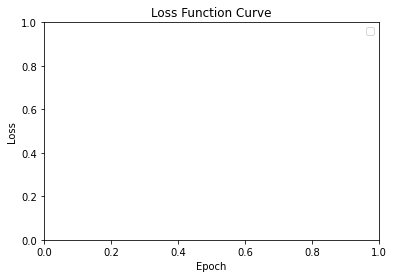

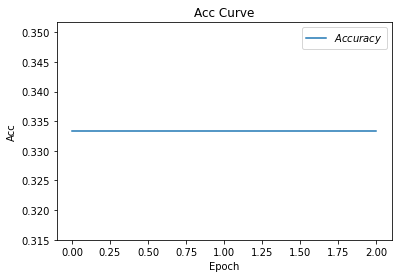

In [49]:
# 测试部分
from matplotlib import pyplot as plt
    # total_correct为预测对的样本个数, total_number为测试的总样本数，将这两个变量都初始化为0
total_correct=0
total_number=0
for x_test, y_test in test_db:
  # 使用更新后的参数进行预测
  y=tf.matmul(x_test, w1) + b1
  y=tf.nn.softmax(y)
  pred=tf.argmax(y, axis=1)  # 返回y中最大值的索引，即预测的分类
  # 将pred转换为y_test的数据类型
  pred=tf.cast(pred, dtype=y_test.dtype)
  # 若分类正确，则correct=1，否则为0，将bool型的结果转换为int型
  correct=tf.cast(tf.equal(pred, y_test), dtype=tf.int32)
  # 将每个batch的correct数加起来
  correct=tf.reduce_sum(correct)
  # 将所有batch中的correct数加起来
  total_correct+=int(correct)
  # total_number为测试的总样本数，也就是x_test的行数，shape[0]返回变量的行数
  total_number+=x_test.shape[0]
# 总的准确率等于total_correct/total_number
acc=total_correct/total_number
test_acc.append(acc)
print("Test_acc:", acc)
print("--------------------------")

# 绘制 loss 曲线
plt.title('Loss Function Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Loss')  # y轴变量名称
# plt.plot(train_loss_results, label="$Loss$")  # 逐点画出trian_loss_results值并连线，连线图标是Loss
plt.legend()  # 画出曲线图标
plt.show()  # 画出图像

# 绘制 Accuracy 曲线
plt.title('Acc Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Acc')  # y轴变量名称
plt.plot(test_acc, label="$Accuracy$")  # 逐点画出test_acc值并连线，连线图标是Accuracy
plt.legend()
plt.show() 